# Visualizing MusicBrainz data related to a composer

For context refer to the previous notebooks

In this notebook and the next ones we're going to explore datasets centered around a MusicBrainz entity (an artist, a work, a recording...) and try to display simple but clear visualisations. We will organize our exploration around simple questions we want answered.

As usual we first write our boilerplate code to access the database:

In [1]:
%matplotlib inline
import pandas
import sqlalchemy
# define DB
PGHOST = "192.168.11.3"
PGDATABASE = "musicbrainz_db"
PGUSER = "musicbrainz"
PGPASSWORD = "musicbrainz"

engine = sqlalchemy.create_engine(
   'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}/{PGDATABASE}'.format(**locals()),
    isolation_level='READ UNCOMMITTED')

# helper function
def sql(query, **kwargs):
    return pandas.read_sql(query, engine, params=globals(), **kwargs)

Let's take a look at the french composer Gabriel Fauré:

In [2]:
composer_name = 'Gabriel Fauré'

In [3]:
query_composer = """
SELECT gid AS mbid,
       name,
       to_date(to_char(begin_date_year, '9999') || 
               to_char(begin_date_month, '99') || 
               to_char(begin_date_day, '99'), 'YYYY MM DD') AS start,
       to_date(to_char(end_date_year, '9999') || 
               to_char(end_date_month, '99') || 
               to_char(end_date_day, '99'), 'YYYY MM DD') AS end
  FROM artist 
 WHERE name = %(composer_name)s;
"""

In [4]:
composer = sql(query_composer)
composer

,mbid,name,start,end
0,fa19a8b6-e7f4-40d4-af15-7a7c41ac7d8f,Gabriel Fauré,1845-05-12,1924-11-04


So now we have the composer unique identifier (mbid) that we can use in future queries.

In [5]:
composer_mbid = composer['mbid'][0]

The MusicBrainz database stores dates as separate year/month/day fields, so I wrote a short function to recombine this information as a Python datetime field.

Let's try to answer a few questions about Fauré now.

### Q: How many works did Fauré compose?

In [7]:
works = sql("""
SELECT w.name,
       w.gid AS mbid
  FROM work          AS w
  JOIN l_artist_work AS law ON w.id = law.entity1
  JOIN artist        AS a   ON a.id = law.entity0
 WHERE a.gid = %(composer_mbid)s;
""")
print('Answer: %d works' % len(works))
print('First works (alphabetical order): ')
works.sort_values(by='name').head(10)

Answer: 424 works
First works (alphabetical order): 


,name,mbid
378,"2 Pieces, op. 104",7477ffff-34d0-4eb0-8baa-37b5529c1ef0
190,"2 offertories, op. 65",d27f6748-0a45-4275-ad47-d98d2b6ca384
377,"3 Nocturnes, op. 33",bb3fb89f-fd1d-4e11-9d23-800f82d05310
375,"3 Songs, op. 23",7e9bcd6d-8d28-4e6e-9bed-9c4fcfd70813
315,"5 Mélodies ""de Venise"", op. 58",6f052afc-5f98-48ae-a145-2af617dbe1a1
96,"5 Mélodies ""de Venise"", op. 58: 1. Mandoline",9411de7b-8e49-37a4-853f-6a773f654930
97,"5 Mélodies ""de Venise"", op. 58: 2. En sourdine",9f02dd6a-2a83-34aa-91ee-9ad852359569
98,"5 Mélodies ""de Venise"", op. 58: 3. Green",112c8069-3a0a-3de0-aa5a-46c3aa415c41
99,"5 Mélodies ""de Venise"", op. 58: 4. À Clymène",c97e8156-879c-3d67-a6e6-29ada013b235
100,"5 Mélodies ""de Venise"", op. 58: 5. C'est l'extase",8d50e954-09ec-3ca8-94a5-41ba52bd0205


Of course this list contains parent works as well as subworks/movements.

If we reduce the selection to the "main" works (i.e. the ones not parts of larger works):

In [8]:
main_works = sql("""
SELECT w.name ,
       w.gid AS mbid
  FROM work          AS w
  JOIN l_artist_work AS law ON w.id = law.entity1
  JOIN artist        AS a   ON a.id = law.entity0
LEFT OUTER JOIN l_work_work AS lww ON w.id = lww.entity1
 WHERE a.gid = %(composer_mbid)s
   AND lww.entity1 IS NULL;
""")
print('Answer: %d works' % len(main_works))
print('First works (alphabetical order): ')
main_works.sort_values(by='name').head(10)

Answer: 161 works
First works (alphabetical order): 


,name,mbid
149,"2 Pieces, op. 104",7477ffff-34d0-4eb0-8baa-37b5529c1ef0
72,"2 offertories, op. 65",d27f6748-0a45-4275-ad47-d98d2b6ca384
148,"3 Nocturnes, op. 33",bb3fb89f-fd1d-4e11-9d23-800f82d05310
146,"3 Songs, op. 23",7e9bcd6d-8d28-4e6e-9bed-9c4fcfd70813
131,"5 Mélodies ""de Venise"", op. 58",6f052afc-5f98-48ae-a145-2af617dbe1a1
137,"9 Préludes, op. 103",82fb11eb-f365-4162-805c-b575bd6233d9
53,"Accompagnement, op. 85 no. 3",d7a435d7-aa7a-3c06-82a6-4f89e2048fe5
142,Allegretto moderato for Two Cellos,30f31cb1-440d-424d-8497-5b86c4f155c1
10,"Allegro symphonique, op. 68",f4f523a3-d7d2-36bb-9f76-4fdfc788be58
159,"Andante (original version of Romance, op. 69)",211fe27c-ae81-4bbe-adac-f90cfb7753df


So 161 works in MusicBrainz. Some of them might be transcriptions/arrangements of Fauré's works and we might want to filter them out, but let's leave that question aside for the moment.

### Q: How many works did Fauré compose each year?

Same query with the begin date. We set works without the begin date to 0.

In [9]:
works_with_dates = sql("""
SELECT w.name, 
       w.gid             AS mbid,
       l.begin_date_year AS begin_date
  FROM work              AS w
  JOIN l_artist_work     AS law ON w.id = law.entity1
  JOIN artist            AS a   ON a.id = law.entity0
  JOIN link              AS l   ON l.id = law.link
LEFT OUTER JOIN l_work_work AS lww ON w.id = lww.entity1
 WHERE a.gid = %(composer_mbid)s
   AND lww.entity1 IS NULL
ORDER BY begin_date;
""")
works_with_dates['begin_date'] = works_with_dates['begin_date'].fillna(0).astype(int)
works_with_dates.head()

,name,mbid,begin_date
0,"Le Papillon et la fleur, op. 1 no. 1",3870dfe2-a5a2-3bd1-8f5f-1ba7c236389c,1861
1,"Mai, op. 1 no. 2",5b5d2077-5bbb-3cb8-8513-2dc47b16af01,1862
2,Puisque j'ai mis ma lèvre,5ba444ba-1281-4278-8e97-3294de089604,1862
3,"Trois romances sans paroles, op. 17",8da1851e-4d0b-4032-9b81-3f6160a309e8,1863
4,"Puisqu'ici-bas toute âme, op. 10 no. 1",c7f84030-184f-4fdf-9c06-280df534708f,1863


Let's look at how many works were composed each year (date 0 = no date information):

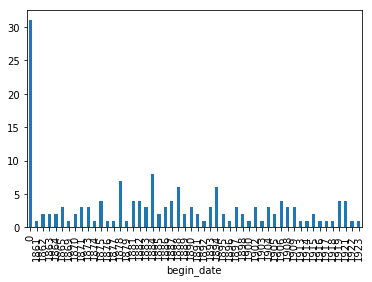

In [10]:
works_with_dates.groupby('begin_date').count()['name'].plot.bar()

### Q: Is Fauré's opus catalogue in MB?

MuscBrainz stores composers catalogue using the Series data type

In [11]:
catalogue = sql("""
SELECT s.gid AS mbid,
       s.name
  FROM series          AS s
  JOIN series_type     AS st  ON s.type = st.id
  JOIN l_artist_series AS las ON s.id = las.entity1
  JOIN artist          AS a   ON a.id = las.entity0
 WHERE st.name = 'Catalogue'
   AND a.gid = %(composer_mbid)s;
""")
catalogue_mbid = catalogue['mbid'][0]
catalogue['url'] = 'https://musicbrainz.org/series/' + str(catalogue['mbid'])
catalogue

,mbid,name,url
0,66036327-cef9-4ed8-8200-07986729c427,Gabriel Fauré’s Opus,https://musicbrainz.org/series/0 66036327-c...


So the answer is yes.

### Q: Are works missing from the catalogue?

In [12]:
works_in_catalogue = sql("""
SELECT lt.text_value AS catalog_no,
       w.name AS work_name,
       w.gid
  FROM work                      AS w
  JOIN l_series_work             AS lsw ON w.id = lsw.entity1
  JOIN series                    AS s   ON s.id = lsw.entity0
  JOIN link_attribute_text_value AS lt  ON lt.link = lsw.link
  WHERE s.gid = %(catalogue_mbid)s
  ORDER BY lsw.link_order ASC;
""")
print('Answer: %d works' % len(works_in_catalogue))
works_in_catalogue.head(10)

Answer: 86 works


,catalog_no,work_name,gid
0,op. 7,"Trois mélodies, op. 7",2b20a2a6-ace0-4b10-97a8-35d89db8ad23
1,op. 12,"Les Djinns, op. 12",462fb304-ea22-4752-a1f1-50c33686cc62
2,op. 13,"Sonata for Violin and Piano no. 1 in A major, ...",5f4a4898-2c4f-408b-b014-07701fb16fff
3,op. 15,"Piano Quartet no. 1 in C minor, op. 15",ddf3869c-d300-4b0e-aaa1-4b54a28f05c1
4,op. 16,Berceuse for Violin (or Cello) and Piano in D ...,621c4838-df42-3232-972c-4c2304a6e12b
5,op. 17,"Trois romances sans paroles, op. 17",8da1851e-4d0b-4032-9b81-3f6160a309e8
6,op. 19,"Ballade en Fa dièse majeur, op. 19",5a8cb6e7-0811-31ec-8816-9b7b2a05c915
7,op. 21,"Poème d'un jour, op. 21",5da85854-21ec-4b52-a6d0-0c3ddc7ee511
8,op. 22,"Le Ruisseau, op. 22",85b675f1-eb0b-44bd-9659-5fcc47c6a1c1
9,op. 24,"Élégie, op. 24",a8564b82-4391-3748-a9a6-f37d3647d655


So it looks like 86 of the ~121 opus numbers are correctly associated in MusicBrainz. Other works are either missing or not linked properly.

### Q: Which languages did Fauré use for vocal works?

We can add to the previous query the work languages (restricted to works present in the catalogue)

In [13]:
works_with_language = sql("""
SELECT w.name AS work,
       l.name AS language
  FROM work                      AS w
  JOIN l_series_work             AS lsw ON w.id = lsw.entity1
  JOIN series                    AS s   ON s.id = lsw.entity0
  JOIN link_attribute_text_value AS lt  ON lt.link = lsw.link
  JOIN language                  AS l   ON l.id = w.language
  WHERE s.gid = %(catalogue_mbid)s
  ORDER BY lsw.link_order ASC;
""")
works_with_language.groupby('language').count()

,work
language,
French,19
Latin,3
No linguistic content,64


As could be expected, a large majority of songs in french and some (religious works) in latin.

### Q: Which tonalities did Fauré use most often?

In [14]:
works_with_key = sql("""
SELECT w.name, 
       wat.value
  FROM work           AS w
  JOIN work_attribute AS wa  ON wa.work = w.id
  JOIN work_attribute_type_allowed_value AS wat ON wat.id = wa.work_attribute_type_allowed_value
  JOIN l_artist_work  AS law ON w.id = law.entity1
  JOIN artist         AS a   ON a.id = law.entity0
 WHERE a.gid = %(composer_mbid)s
   AND wa.work_attribute_type=1;
""")
tonalities = works_with_key.groupby('value').count().sort_values(by='name', ascending=False)
tonalities

,name
value,
D-flat major,8
A-flat major,7
D minor,6
E minor,6
A minor,5
F-sharp minor,4
E-flat major,4
C minor,4
C-sharp minor,4


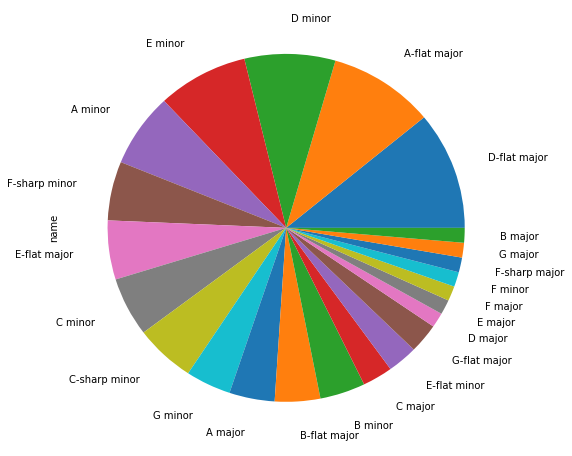

In [15]:
tonalities.plot.pie(y='name', figsize=(8, 8), 
                    startangle=0, labeldistance=1.2, legend=False,
                    colors=None) 

D-flat major, A-flat major, D minor and E minor seem to be Fauré's favorite tonalities.

### Q: Which work types did Fauré most use?

That one is tricky since MuscBrainz doesn't give a lot of choices for work types. Another possibility would be to look at tags.

In [16]:
works_with_type = sql("""
SELECT w.name, 
       wt.name AS type
  FROM work           AS w
  JOIN work_type      AS wt  ON w.type = wt.id
  JOIN l_artist_work  AS law ON w.id = law.entity1
  JOIN artist         AS a   ON a.id = law.entity0
 WHERE a.gid = %(composer_mbid)s;
""")
types = works_with_type.groupby('type').count().sort_values(by='name', ascending=False)
types

,name
type,
Song,115
Song-cycle,7
Suite,7
Mass,4
Sonata,4
Quartet,3
Cantata,1
Incidental music,1
Madrigal,1


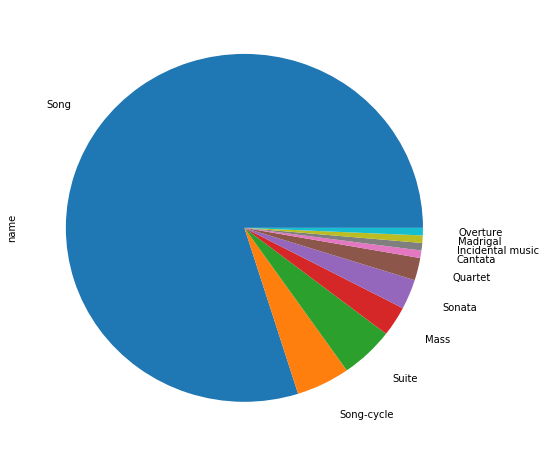

In [17]:
types.plot.pie(y='name', figsize=(8, 8), 
               startangle=0, labeldistance=1.2, legend=False,
               colors=None) 
# XXXchange colors

So in the standard work types, the Song seems to be a large majority. Note that specific chamber music work types (quartet, quintet...) do not exist in MusicBrainz.

## Apply to other composers

If you want to reproduce on other composers, it might be easier to combine all queries above in one that will look like:

In [18]:
def data(composer_name):
    composer = sql("""
SELECT gid AS mbid,
       name
  FROM artist 
 WHERE name=%(composer_name)s;
    """)
    composer_mbid = composer['mbid'][0]

    df = sql("""
SELECT w.gid AS mbid,
       lt.text_value AS catalog_no,
       w.name AS work_name,
       la.name AS language,
       wt.name AS work_type,
       watav.value AS key, 
       l.begin_date_year, 
       l.end_date_year
  FROM work          AS w
  JOIN l_artist_work AS law ON w.id = law.entity1
  JOIN artist        AS a   ON a.id = law.entity0
  JOIN link          AS l   ON l.id = law.link
LEFT OUTER JOIN l_series_work                     AS lsw ON w.id = lsw.entity1
LEFT OUTER JOIN series                            AS s   ON s.id = lsw.entity0
LEFT OUTER JOIN link_attribute_text_value         AS lt  ON lt.link = lsw.link
LEFT OUTER JOIN language                          AS la  ON la.id = w.language
LEFT OUTER JOIN work_type                         AS wt  ON w.type = wt.id
LEFT OUTER JOIN work_attribute                    AS wa  ON wa.work = w.id
LEFT OUTER JOIN work_attribute_type               AS wat   ON wat.id = wa.work_attribute_type
LEFT OUTER JOIN work_attribute_type_allowed_value AS watav ON watav.id = wa.work_attribute_type_allowed_value
 WHERE a.gid = %(composer_mbid)s
   AND wat.name = 'Key';
    """)
    return df

In [19]:
data('Franz Schubert')

,mbid,catalog_no,work_name,language,work_type,key,begin_date_year,end_date_year
0,fb2cfb0a-aad7-336e-82d4-268c527da5a1,op. 107,"Nocturne no. 12 en Mi mineur, op. 107",No linguistic content,None,E minor,1915.0,1915.0
1,50513f08-231c-3048-ad0a-cad16a20d85c,op. 119,"Nocturne no. 13 en Si mineur, op. 119",No linguistic content,None,B minor,1921.0,1921.0
2,5a8cb6e7-0811-31ec-8816-9b7b2a05c915,op. 19,"Ballade en Fa dièse majeur, op. 19",No linguistic content,None,F-sharp major,1879.0,1879.0
3,eae1692b-28d7-3ba2-b281-762017db9800,None,"Prélude no. 1 en Ré bémol majeur, op. 103",No linguistic content,None,D-flat major,1910.0,1910.0
4,fa9e9049-4c07-389c-a696-b97276b2262f,None,"Prélude no. 2 en Ut dièse mineur, op. 103",No linguistic content,None,C-sharp minor,1910.0,1910.0
5,d4610cdb-51fe-3ead-a2b6-e619f5e8b4d9,None,"Prélude no. 3 en Sol mineur, op. 103",No linguistic content,None,G minor,1910.0,1910.0
6,1764d098-3830-3d2e-a4fd-0c664352e625,None,"Prélude no. 4 en Fa majeur, op. 103",No linguistic content,None,F major,1910.0,1910.0
7,0c2c11e8-8f6b-3fe0-9707-27b66d21ff67,None,"Prélude no. 5 en Ré mineur, op. 103",No linguistic content,None,D minor,1910.0,1910.0
8,64e7cda5-5ce7-3323-8d45-841fa15df282,None,"Prélude no. 6 en Mi bémol mineur, op. 103",No linguistic content,None,E-flat minor,1910.0,1910.0
9,47c4732b-621d-34fc-b1a8-89a50e4224db,None,"Prélude no. 7 en La majeur, op. 103",No linguistic content,None,A major,1910.0,1910.0


## Comparing composers

Let's compare composers born before 1900 who wrote the most works:

In [20]:
sql("""
SELECT a.name, COUNT(a.name)
  FROM work          AS w
  JOIN l_artist_work AS law ON w.id = law.entity1
  JOIN artist        AS a   ON a.id = law.entity0
LEFT OUTER JOIN l_work_work AS lww ON w.id = lww.entity1
 WHERE a.begin_date_year < 1900
   AND lww.entity1 IS NULL
 GROUP BY a.name 
 HAVING COUNT(a.name) > 500
 ORDER BY COUNT(a.name) DESC
 LIMIT 10;
""")

,name,count
0,Johann Sebastian Bach,1359
1,Wolfgang Amadeus Mozart,1062
2,Franz Schubert,942
3,George Frideric Handel,755
4,Ludwig van Beethoven,703
5,Antonio Vivaldi,675
6,Domenico Scarlatti,572
7,Jean Sibelius,537
